# Advanced Lane Finding Project

## Project Objective

Develop an image processing pipeline that can identify lane lines, measure the radius of the curve(if any), identify the center of the lane, determine how far off-center the vehicle is currently driving, and clearly label identfied lines and lane space.




In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


##### Camera Calibration

1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for calibrating the camera is located in the cell below. The camera calibration routine works by finding the corner pixels of a pattern with know values and parallelism qualities. The pattern is important to be able to detection distortion in a camera lens. Each of the detected corners is an object point in worldspace. Since we know the true geometry of the objpoints in world space, we can measure any deviation and calculate lens distortion from these values. OpenCV provides the findChessboardCorners and CalibrateCamera functions which perform this function. CalibrateCamera returns the correction coefficcients which can then be applied to new images using the undistort function. Examples of a distorted and an undistorted image are shown below.

In [2]:
#Calibration



# Read in all of the calibration images provided in the camera_cal directory

images = [cv2.imread(file) for file in glob.glob("camera_cal/*.jpg")]

#Prepare an array for storing the object points

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
objpoints = []
imgpoints = []

# Variables that desribe the amount of corners in the calibration chessboard

nx = 9
ny = 6

# Iterate through the list of calibration images, convert to grayscale and use the opencv2 fucnction
# to find the pixel coordinates for the cheesboard corners.

for image in images:
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners on the calibration image
    if ret == True:
        # Draw and display the corners
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(image, (9,6), corners, ret)
     
        cv2.imshow('img', image)
        cv2.waitKey(50)
cv2.destroyAllWindows()

#Return the distortion coefficients so they can be used to undistort the images taken with the same camera

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)


##### Image processing pipeline(Images)

1. An example of an undistorted image is shown below.

True

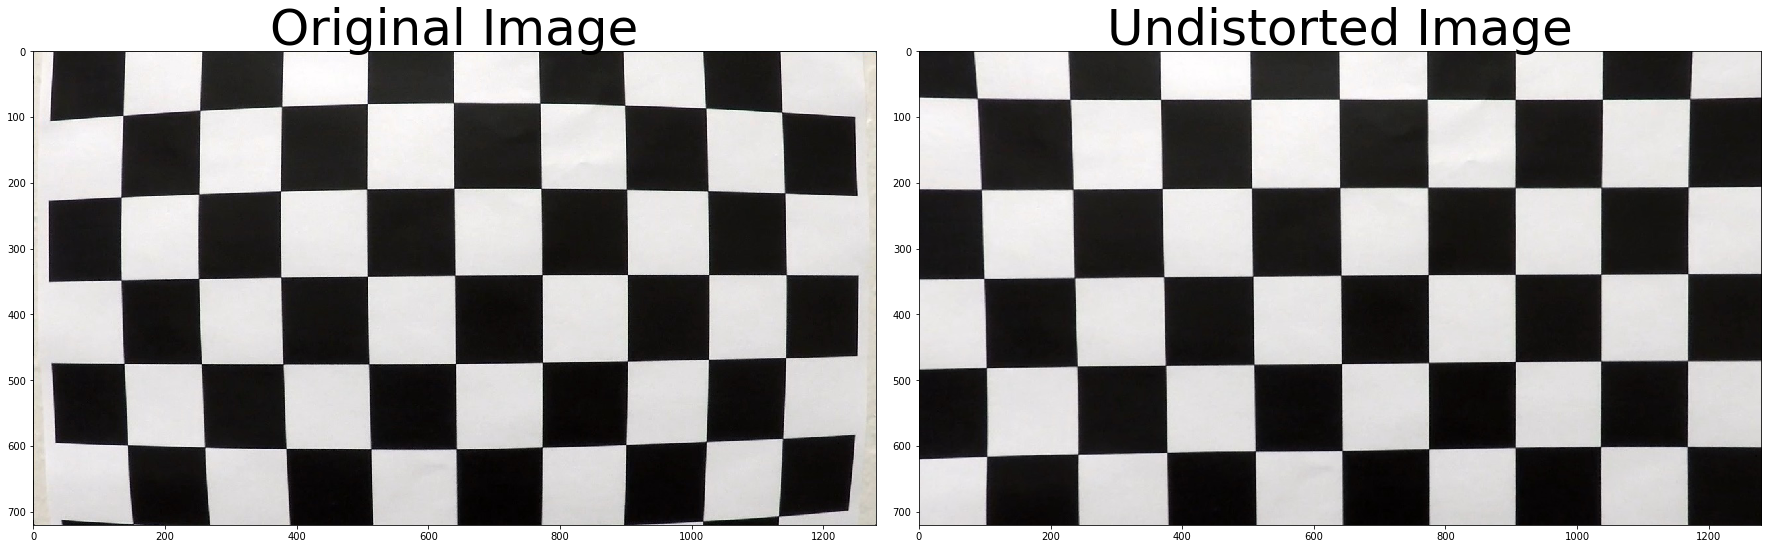

In [3]:
# Undistort and image to verify that everything is working correctly

img = mpimg.imread('camera_cal/calibration1.jpg')

undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('UndistortedImage-test2.jpg',undistorted)

In [4]:
#### My pseudo Code for the project ######

#get lens calibration values
#slice video into images
#apply lens calibration to video images
#warp video images so they display an overhead view
#Figure out what colorspace I want to used to detect lane lines(simplecv tool could be useful here)
#Take colorspace shifted images and use rectangle histogram method to identfy location of lane lines
#Shift rectangle upwards and repeat until completed for the whole image
#take lane line locations and generate a polyfit curve that best fits through their centers
#Draw the polyfit line in yellow
#Draw a rectange the space between the lines in grew
#calculate the center of the lane
#calculate the distance of the vehicle from center
#calculate the radius of the curve
#dewarp the resultant image with identified lane lines
#display the calculated radius, centerm and distance from center
#Repeat for all images
#Recreate video from processed images

##### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

My image processing pipeline made extensive use of gradient and color threhold binary images in order to create a robust outline of the lane lines. Colorspaces used included the RGB(R Channel), HLS(S Channel), and LUV(L Channel). The RGB channel was used to detect yellow lines. The S Channel was used to detect both white and yellow lines in bright lighting conditions. The L channel was used to detect lane lines in dark lighting conditions. Each of the color channel images was converted to a binary image to aid in lane line detection further on in the pipeline. In addition to the Color transforms that were applied, Sobel(X and Y) and Magnitude gradients were used to further detect lane line pixels. In the final pipeline I used combinational logic(AND and OR) to provide a stronger lane line pixel detection process. Examples of each of these transforms and the subsequent combinations are show in the next series of code cells. 


In [5]:
################# S Channel Color transform ###########################

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

################# L Channel Color transform ###########################

def luv_select(img, thresh=(0, 255)):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    l,u,v = cv2.split(luv)
    binary_output = np.zeros_like(l)
    binary_output[(l > thresh[0]) & (l <= thresh[1])] = 1
    return binary_output

################# R Channel Color transform ###########################

def rgb_select(img, thresh=(0, 255)):
    r,g,b = cv2.split(img)
    binary_output = np.zeros_like(r)
    binary_output[(r > thresh[0]) & (r <= thresh[1])] = 1
    return binary_output

################# Absolute Gradient Binary threhold transform ###########################

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

################# Magnitude Gradient Binary threhold transform ###########################

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [6]:
# Read in the images provided for pipeline testing as part of the project directory

img1 = mpimg.imread('test_images/test1.jpg')
img2 = mpimg.imread('test_images/test2.jpg')
img3 = mpimg.imread('test_images/test3.jpg')
img4 = mpimg.imread('test_images/test4.jpg')
img5 = mpimg.imread('test_images/test5.jpg')
img6 = mpimg.imread('test_images/test6.jpg')
img7 = mpimg.imread('test_images/straight_lines1.jpg')
img8 = mpimg.imread('test_images/straight_lines2.jpg')

undistorted1 = cv2.undistort(img1, mtx, dist, None, mtx)
undistorted2 = cv2.undistort(img2, mtx, dist, None, mtx)
undistorted3 = cv2.undistort(img3, mtx, dist, None, mtx)
undistorted4 = cv2.undistort(img4, mtx, dist, None, mtx)
undistorted5 = cv2.undistort(img5, mtx, dist, None, mtx)
undistorted6 = cv2.undistort(img6, mtx, dist, None, mtx)

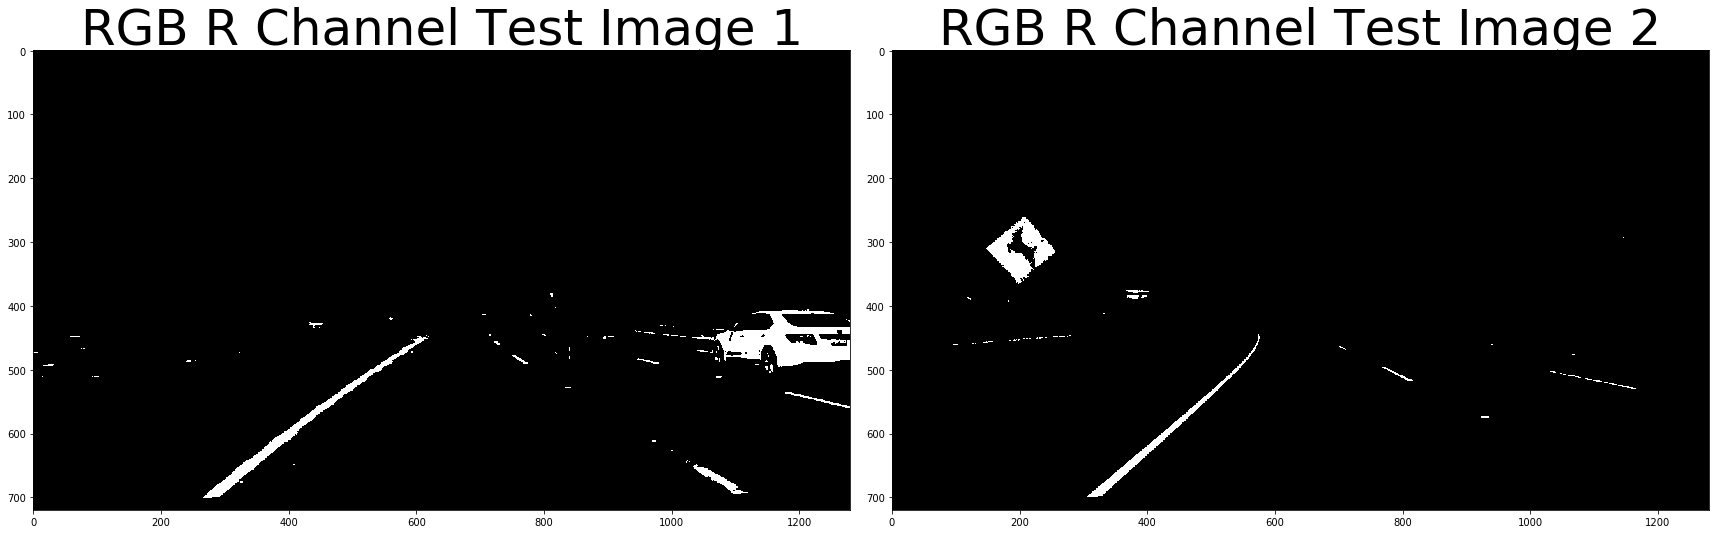

In [7]:
################# Apply the R Channel transform to the test images ###########################

min = 220
max = 255

r_channel1 = rgb_select(undistorted1, thresh=(min, max))
r_channel2 = rgb_select(undistorted2, thresh=(min, max))
r_channel3 = rgb_select(undistorted3, thresh=(min, max))
r_channel4 = rgb_select(undistorted4, thresh=(min, max))
r_channel5 = rgb_select(undistorted5, thresh=(min, max))
r_channel6 = rgb_select(undistorted6, thresh=(min, max))
    
f1, (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
f1.tight_layout()
x1.imshow(r_channel1, cmap='gray')
x1.set_title('RGB R Channel Test Image 1', fontsize=50)
x2.imshow(r_channel2, cmap='gray')
x2.set_title('RGB R Channel Test Image 2', fontsize=50)


In [ ]:




upper = 255
lower = 180

hls_binary1 = hls_select(undistorted1, thresh=(lower,upper))
hls_binary2 = hls_select(undistorted2, thresh=(lower,upper))
hls_binary3 = hls_select(undistorted3, thresh=(lower,upper))
hls_binary4 = hls_select(undistorted4, thresh=(lower,upper))
hls_binary5 = hls_select(undistorted5, thresh=(lower,upper))
hls_binary6 = hls_select(undistorted6, thresh=(lower,upper))



f1, (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
f1.tight_layout()
x1.imshow(hls_binary1, cmap='gray')
x1.set_title('HLS S Channel Test Image 1', fontsize=50)
x2.imshow(hls_binary2, cmap='gray')
x2.set_title('HLS S Channel Test Image 2', fontsize=50)


In [ ]:
lower_th = 200
upper_th = 230


luv_binary1 = luv_select(undistorted1, thresh=(lower_th, upper_th))
luv_binary2 = luv_select(undistorted2, thresh=(lower_th, upper_th))
luv_binary3 = luv_select(undistorted3, thresh=(lower_th, upper_th))
luv_binary4 = luv_select(undistorted4, thresh=(lower_th, upper_th))
luv_binary5 = luv_select(undistorted5, thresh=(lower_th, upper_th))
luv_binary6 = luv_select(undistorted6, thresh=(lower_th, upper_th))

f1, (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
f1.tight_layout()
x1.imshow(luv_binary1, cmap='gray')
x1.set_title('LUV L Channel Test Image 1', fontsize=50)
x2.imshow(luv_binary2, cmap='gray')
x2.set_title('LUV L Channel Test Image 2', fontsize=50)


In [ ]:

min = 20
max = 200
grad_binary1x = abs_sobel_thresh(undistorted1, orient='x', thresh_min=min, thresh_max=max)
grad_binary2x = abs_sobel_thresh(undistorted2, orient='x', thresh_min=min, thresh_max=max)
grad_binary3x = abs_sobel_thresh(undistorted3, orient='x', thresh_min=min, thresh_max=max)
grad_binary4x = abs_sobel_thresh(undistorted4, orient='x', thresh_min=min, thresh_max=max)
grad_binary5x = abs_sobel_thresh(undistorted5, orient='x', thresh_min=min, thresh_max=max)
grad_binary6x = abs_sobel_thresh(undistorted, orient='x', thresh_min=min, thresh_max=max)


f1, (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
f1.tight_layout()
x1.imshow(grad_binary1x, cmap='gray')
x1.set_title('Sobel X Image 1', fontsize=50)
x2.imshow(grad_binary2x, cmap='gray')
x2.set_title('Sobel X Image 2', fontsize=50)


In [ ]:
min = 20
max = 200

grad_binary1y = abs_sobel_thresh(undistorted1, orient='y', thresh_min=min, thresh_max=max)
grad_binary2y = abs_sobel_thresh(undistorted2, orient='y', thresh_min=min, thresh_max=max)
grad_binary3y = abs_sobel_thresh(undistorted3, orient='y', thresh_min=min, thresh_max=max)
grad_binary4y = abs_sobel_thresh(undistorted4, orient='y', thresh_min=min, thresh_max=max)
grad_binary5y = abs_sobel_thresh(undistorted5, orient='y', thresh_min=min, thresh_max=max)
grad_binary6y = abs_sobel_thresh(undistorted6, orient='y', thresh_min=min, thresh_max=max)


f1, (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
f1.tight_layout()
x1.imshow(grad_binary1y, cmap='gray')
x1.set_title('Sobel Y Image 1', fontsize=50)
x2.imshow(grad_binary2y, cmap='gray')
x2.set_title('Sobel Y Image 2', fontsize=50)


In [ ]:
min = 50
max = 160
mag_binary1 = mag_thresh(undistorted1, sobel_kernel=3, mag_thresh=(min, max))
mag_binary2 = mag_thresh(undistorted2, sobel_kernel=3, mag_thresh=(min, max))
mag_binary3 = mag_thresh(undistorted3, sobel_kernel=3, mag_thresh=(min, max))
mag_binary4 = mag_thresh(undistorted4, sobel_kernel=3, mag_thresh=(min, max))
mag_binary5 = mag_thresh(undistorted5, sobel_kernel=3, mag_thresh=(min, max))
mag_binary6 = mag_thresh(undistorted6, sobel_kernel=3, mag_thresh=(min, max))


f1, (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
f1.tight_layout()
x1.imshow(mag_binary1, cmap='gray')
x1.set_title('Mag Thresh Image 1', fontsize=50)
x2.imshow(mag_binary2, cmap='gray')
x2.set_title('Mag Thresh Image 2', fontsize=50)


In [ ]:
and_image1 = cv2.bitwise_and(luv_binary1, hls_binary1)
and_image2 = cv2.bitwise_and(luv_binary2, hls_binary2)
and_image3 = cv2.bitwise_and(luv_binary3, hls_binary3)
and_image4 = cv2.bitwise_and(luv_binary4, hls_binary4)
and_image5 = cv2.bitwise_and(luv_binary5, hls_binary5)
and_image6 = cv2.bitwise_and(luv_binary6, hls_binary6)

sobel_and1 = cv2.bitwise_and(grad_binary1x, grad_binary1y)
sobel_and2 = cv2.bitwise_and(grad_binary2x, grad_binary2y)
sobel_and3 = cv2.bitwise_and(grad_binary3x, grad_binary3y)
sobel_and4 = cv2.bitwise_and(grad_binary4x, grad_binary4y)
sobel_and5 = cv2.bitwise_and(grad_binary5x, grad_binary5y)
sobel_and6 = cv2.bitwise_and(grad_binary6x, grad_binary6y)

and1 = cv2.bitwise_and(mag_binary1, r_channel1)
and2 = cv2.bitwise_and(mag_binary2, r_channel2)
and3 = cv2.bitwise_and(mag_binary3, r_channel3)
and4 = cv2.bitwise_and(mag_binary4, r_channel4)
and5 = cv2.bitwise_and(mag_binary5, r_channel5)
and6 = cv2.bitwise_and(mag_binary6, r_channel6)

or_image1 = cv2.bitwise_or(and_image1, sobel_and1, and1)
or_image2 = cv2.bitwise_or(and_image2, sobel_and2, and2)
or_image3 = cv2.bitwise_or(and_image3, sobel_and3, and3)
or_image4 = cv2.bitwise_or(and_image4, sobel_and4, and4)
or_image5 = cv2.bitwise_or(and_image5, sobel_and5, and5)
or_image6 = cv2.bitwise_or(and_image6, sobel_and6, and6)

f1, (x1, x2) = plt.subplots(1, 2, figsize=(24, 9))
f1.tight_layout()
x1.imshow(or_image1, cmap='gray')
x1.set_title('Final Transform Image 1', fontsize=50)
x2.imshow(or_image2, cmap='gray')
x2.set_title('Final Transform  Image 2', fontsize=50)



##### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code below applies a perspective transform to the lane region. The SRC points are manually selected from an image where the lanes are straight. The destination points are chosen to form a rectangle as we want to take the normal view and create a new "top down" view. The getPerspectiveTransform function is used to both warp and unwarp the images. The warpPerspective function applies the previously generated M or M_inv warp coefficients to an image.

In [ ]:
# Select Source Points
src_bottom_left = [570,468] 
src_bottom_right = [714,468]
src_top_left = [207,720]
src_top_right = [1106,720]

source = np.float32([src_bottom_left,src_bottom_right,src_top_right,src_top_left])

image_shape = (720,1280)

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [320,720] 
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]

dst = np.float32([top_left,top_right,bottom_right, bottom_left])

M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)
img_size = (image_shape[1], image_shape[0])

warped1 = cv2.warpPerspective(or_image1, M, img_size , flags=cv2.INTER_LINEAR)
warped2 = cv2.warpPerspective(or_image2, M, img_size , flags=cv2.INTER_LINEAR)
warped3 = cv2.warpPerspective(or_image3, M, img_size , flags=cv2.INTER_LINEAR)
warped4 = cv2.warpPerspective(or_image4, M, img_size , flags=cv2.INTER_LINEAR)
warped5 = cv2.warpPerspective(or_image5, M, img_size , flags=cv2.INTER_LINEAR)
warped6 = cv2.warpPerspective(or_image6, M, img_size , flags=cv2.INTER_LINEAR)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(or_image1, cmap='gray')
ax1.set_title('Image 1', fontsize=50)
ax2.imshow(warped1, cmap='gray')
ax2.set_title('Warped Image 1', fontsize=50)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(or_image2, cmap='gray')
ax1.set_title('Image 2', fontsize=50)
ax2.imshow(warped2, cmap='gray')
ax2.set_title('Warped  Image 2', fontsize=50)




##### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

The lane line pixels are using the method outlined in the lecture. The algorithm can be broken down to the following basic steps.

1. Take a histogram of the bottom half of a top down view of the lane line binary image.
2. Detect the peak in the left half and right half of the image. 
3. Use the x location of the left and right peaks to begin a more detailed scan for the lane lines starting from the bottom of the image.
4. Decide how many scan steps you would like to perform in the y direction. This is hardcoded and equal to (Image Height/Scan Steps) = Scan Height. Scan Width is Fixed at 100.
5. Within this rectangle count how many white pixels there are. If there are more than fifty then a lane line is considered detected, and the centroid is calculated. 
6. The rectangle is drawn around the white pixel blob centroid.
7. This is repeated all the way to the top of the picture.
8. Use a polyfit function to defined a polyfit line through the center of the left and right rectangle centroids.

##### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

The radius of the curvature of the line can be found using the formula

![alt text](RoC.jpg "Radius of Curvature Formula")

This is coded in python as

###### ((1 + (2*left_fitcr[0]*y_eval*ym_per_pix + left_fitcr[1])**2)**1.5) / np.absolute(2*left_fitcr[0])

Ym_per_pix is a constant value that describes meters in the Y direction per pixel. This value is a suggested value from the Udacity lecture.

The radius of the curve is calculated and displayed in an image below.

The center of the image is assumed to be the center of the car. The center of the lane is calculated by finding the distance between the left and right detected lanes. Once we have identified the center lane pixel, we can calculate the distance the lane center is from the image center and multiply the difference in pixel by Yx_per_pix. Yx_per_pix describes how many meters in the x direction a pixel represents. The calculated center offset is located in the resultant image a couple of cells down.


6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

An example with an identified lane(green) as well as left and right lane radius and center offset displayed is located below.

In [ ]:
histogram = np.sum(warped2[warped2.shape[0]//2:,:], axis=0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))

ax1.imshow(warped2, cmap='gray')
ax2.plot(histogram)

In [ ]:


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[100:midpoint])
    rightx_base = np.argmax(histogram[midpoint:1100]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 30
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

left_fitx_hist=[]
right_fitx_hist=[]

def fit_polynomial(binary_warped, Minv, undist):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    global left_fitx_hist
    left_fitx_hist.append(left_fitx)
    
    var = 120
   
    if len(left_fitx_hist)>var:
        left_fitx_hist=left_fitx_hist[-(var-1):]
    left_fitx_hist.append(left_fitx)
        
        
    #Build right fit history in order to identify outliers
    
    global right_fitx_hist
    right_fitx_hist.append(right_fitx)
    
    if len(right_fitx_hist)>var:
        right_fitx_hist=right_fitx_hist[-(var-1):]
    right_fitx_hist.append(right_fitx)
    

    left_fitx_mean = np.mean(np.array(left_fitx_hist), axis=0 )[:len(ploty)]
    right_fitx_mean = np.mean(np.array(right_fitx_hist), axis=0 )[:len(ploty)] 


    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    #Caclculate the radius of the curves
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700 
    left_fitcr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fitcr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    y_eval = np.max(ploty)
    left_curve_rad = ((1 + (2*left_fitcr[0]*y_eval*ym_per_pix + left_fitcr[1])**2)**1.5) / np.absolute(2*left_fitcr[0])
    right_curve_rad = ((1 + (2*right_fitcr[0]*y_eval*ym_per_pix + right_fitcr[1])**2)**1.5) / np.absolute(2*right_fitcr[0])
    print("The radius of curvature is:", left_curve_rad, "m", right_curve_rad, "m")

    #calculate the fill poly area between the lane lines
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx_mean, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx_mean, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.8, 0)

    
    # Add text to an image
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    topline_text = 'Curvature: L %.3fm  R %.3fm' % (left_curve_rad, right_curve_rad)

    # how to calculate camera offset
    camera_position = image.shape[1]/2
    lane_center = (right_fitx[719] + left_fitx[719])/2
    center_offset_pixels = camera_position - lane_center
    center_offset_dist = center_offset_pixels * xm_per_pix

    bottomline_text = 'Offset: %.3fm' % (center_offset_dist)
    
    cv2.putText(result,topline_text,(10,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,bottomline_text,(10,100), font, 1, (255,255,255),2,cv2.LINE_AA)
    
    return result




In [ ]:
result= fit_polynomial(warped5, M_inv, undistorted5)

plt.imshow(result)

In [ ]:
# Select Source Points
src_bottom_left = [570,468] 
src_bottom_right = [714,468]
src_top_left = [207,720]
src_top_right = [1106,720]

source = np.float32([src_bottom_left,src_bottom_right,src_top_right,src_top_left])

image_shape = (720,1280)

# Destination points are chosen such that straight lanes appear more or less parallel in the transformed image.
bottom_left = [320,720] 
bottom_right = [920, 720]
top_left = [320, 1]
top_right = [920, 1]
    
dst = np.float32([top_left,top_right,bottom_right, bottom_left])
M = cv2.getPerspectiveTransform(source, dst)
M_inv = cv2.getPerspectiveTransform(dst, source)
img_size = (image_shape[1], image_shape[0])

def pipeline(img):
    
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    hls_binary = hls_select(undistorted, thresh=(180, 255))
    r_channel = rgb_select(img, thresh=(220, 255))
    grad_binary_x =  abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100) 
    grad_binary_y =  abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 255))
    luv_binary = luv_select(undistorted1, thresh=(200, 230))
    
    and_image1 = cv2.bitwise_and(hls_binary, luv_binary)
    sobel_and1 = cv2.bitwise_and(grad_binary_x, grad_binary_y)
    and1 = cv2.bitwise_and(r_channel, mag_binary)
    
    
    or_image =cv2.bitwise_or(and_image1, sobel_and1, and1)
    
    
    #or_image = cv2.bitwise_or(or_image0, and_image, r_channel)
    
    warped = cv2.warpPerspective(or_image, M, img_size , flags=cv2.INTER_LINEAR)
    res = fit_polynomial(warped, M_inv, undistorted)
    
    return res

In [ ]:
testout1 = pipeline(img1)
testout2 = pipeline(img2)
testout3 = pipeline(img3)
testout4 = pipeline(img4)
testout5 = pipeline(img5)
testout6 = pipeline(img6)
testout7 = pipeline(img7)
testout8 = pipeline(img8)

plt.imshow(testout1)
mpimg.imsave('testout1.jpg',testout1)
mpimg.imsave('testout2.jpg',testout2)
mpimg.imsave('testout3.jpg',testout3)
mpimg.imsave('testout4.jpg',testout4)
mpimg.imsave('testout5.jpg',testout5)
mpimg.imsave('testout6.jpg',testout6)
mpimg.imsave('testout7.jpg',testout7)
mpimg.imsave('testout8.jpg',testout8)

##### Pipeline (video)

1. Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here is a link to my final video hosted on youtube.[My final video](https://youtu.be/iA6K0D77vGk "My final video")

This video can be recreated by running all of the cells within the Advanced Lane Finding Project.ipynb from within the standard udacity project repo.


In [ ]:
yellow_output = 'testvideo.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video.mp4')
yellow_clip = clip2.fl_image(pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)


##### Discussion

1. Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

Challenges:

Color space transformations: I struggled to find the correct combination of color, gradient, and binary thresholds that would allow for yellow and white lane detection in lit and shaded as well as against different pavements. This really highlights the difficulty in creating a universal solution since there was a lot of variation in conditions during just 50 seconds of driving. Additionally I struggled to find the right threshold values for each transform/gradient. A helper app with sliders that allow for quicker experimentation of values would have sped this up significantly. 

Pipeline Weaknesses:

Changing light conditions: The current pipeline is manually tuned for well lit conditions. Driving at night or in bad weather will have negative effects on the ability of this pipeline to identify lane lines.

Tight Radius Turns: Due to extensive use of polyline averaging I don't think this pipeline will work well for tight turns.

Pavement Color: Pavement color can negatively impact the ability of the pipeline to discern lane lines. For example a red(HOV Lane in VA) or green(Bike lanes in DC) paved road could blend in with a yellow lane thus making it invisible to the algorithm.

Faded Lane Lines: Not all lane lines are created equal! Some municipalities struggle to maintain large road networks causing some lane lines to become discernable over time. My pipeline would struggle to identify these worn out lanes.

Obfuscated Lane Lines: If there is an object on the road covering the lane line my pipeline will not be able to infer that there is a lane line under the object.



